# Demonstration of Continuous data event recognition using Semantic Segmentation Models

## Import Dependencies

In [1]:
import sys
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import tensor, cuda
import pandas as pd
import requests


### Add utils to sys to import our custom scripts
**Note:** This notebook should be run from the `examples` folder to ensure the correct imports and file paths are used.

In [ ]:
# Go up one level from 'examples' and point to 'utils' folder
utils_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'utils'))
# Add the 'utils' folder to sys.path
sys.path.append(utils_path)
models_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'models'))
# Add the 'models' folder to sys.path
sys.path.append(models_path)
import data_utils
import model_utils

### Load the model

Model can be loaded through the model_selector() function. Available architectures are: "UNet", "UNetPlusPlus", "DeepLabV3", "SwinUNet", and PhaseNet. If you wish to load the weights generated by the article, you can set the pretrained argument to True, it automatically downloads the weights from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15098817.svg)](https://doi.org/10.5281/zenodo.15098817) (weights are only available for input size N=256). Number of parameters for each model at each input size evaluated in the article is shown below:

In [3]:
device = "cuda" if cuda.is_available() == True else "cpu"
model = model_utils.model_selector(arch='UNet', N=256, pretrained=True).to(device)

UNet.pt Already downloaded
Loading weights...
Succesfuly loaded weights


### Load continuous trace

Data can be downloaded from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.17163020.svg)](https://doi.org/10.5281/zenodo.17163020):

In [4]:
doi = "10.5281/zenodo.17163020"
record_id = doi.split(".")[-1]
metadata_url = f"https://zenodo.org/api/records/{record_id}"
response = requests.get(metadata_url)
metadata = response.json()
files = metadata["files"]


In [5]:
file_to_download = files[4]  # 0: NVCh_10h_continuous_trace.zip - https://zenodo.org/api/records/17163020/files/NVCh_10h_continuous_trace.zip/content
print(file_to_download["key"] )
file_url = file_to_download["links"]["self"]
filename = file_to_download["key"] 
response = requests.get(file_url, stream=True)

with open(filename, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)
print(f"Downloaded {filename}")

print(f"Extracting files...")

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())  # or use a specific path
print(f"Files extracted")

NVCh_10h_continuous_trace.zip
Downloaded NVCh_10h_continuous_trace.zip
Extracting files...
Files extracted


After downloading we load the full seismic trace and the reference dataframe

In [6]:
filename = "NVCh_10h_continuous_trace.npy"

In [7]:
continuous_trace = np.load(filename)
reference = pd.read_csv("NVCh_10h_continuous_trace_reference.csv")
reference.value_counts("event_type")

event_type
LP    55
IC    51
TR    38
VT    38
AV    23
Name: count, dtype: int64

## Sliding window:

We apply our model in a sliding window setup. Stride can be manually selected and is by default set to 2000 (20 seconds). Batch size can also be selected and is by default 16

In [8]:
batch_size = 16
window_size = 8192
stride = 2000

activation_buffer = np.zeros([6,continuous_trace.shape[1]])
n_windows = ((continuous_trace.shape[1] - window_size) // stride) + 1
print_interval = int(n_windows/5)

In [9]:
%%time
_ = model.eval()
window_index = 0
for batch in data_utils.generate_overlapping_batches(
    continuous_trace, window_size=window_size, stride=stride, batch_size=batch_size
):
    X = data_utils.patch_stacking_X(tensor(batch[:, 1:9, :])).to(device)
    output = model(X)
    output = data_utils.activation_unstacking(output, window_size, 256, 6)
    for idx in range(len(output)):
        offset = window_index * stride            
        probabilities = output[idx].detach().cpu().numpy()
        activation_buffer[:,offset:offset+window_size]=activation_buffer[:,offset:offset+window_size]+probabilities
        window_index += 1
        if window_index % print_interval == 0:
            print("windows processed:",window_index, "/", n_windows)


windows processed: 365 / 1829
windows processed: 730 / 1829
windows processed: 1095 / 1829
windows processed: 1460 / 1829
windows processed: 1825 / 1829
CPU times: total: 36.9 s
Wall time: 6.77 s


To obtain the time segmentation we must unstack and binarize the activations for each class:

In [10]:
max_indices = np.argmax(activation_buffer, axis=0)
binarized_activations = np.eye(len(activation_buffer))[max_indices].T

After unstacking and binarizing, we can find start and end times for the detected events. We can obtain a proxy for classification confidence by summing the non-binarized activations. In the following script we record model confidence for the first and second most probable class assignments:

In [11]:
indices_start_, indices_end_ = data_utils.get_events(binarized_activations[0])

label_map = {1: "VT", 2: "LP", 3: "TR", 4: "AV", 5: "IC"}
events = []

for idx_start_,idx_end_ in zip(indices_start_,indices_end_):
    class_act = activation_buffer[1:,idx_start_:idx_end_].sum(axis=1)
    if idx_end_-idx_start_>50:
        class_act = (class_act/class_act.sum())*100
        idx_desc = np.argsort(-class_act)+1      # or: arr.argsort()[::-1]
        pred_label = label_map[idx_desc[0]]
        second_pred_label = label_map[idx_desc[1]]
        conf_1 = class_act[idx_desc[0]-1]
        conf_2 = class_act[idx_desc[1]-1]
        events.append([pred_label, idx_start_, idx_end_,second_pred_label, np.round(conf_1,1),np.round(conf_2,1)])

cols = ["pred_label", "idx_start", "idx_end", "second_pred_label", "conf_1", "conf_2"]
predicted_df = pd.DataFrame(events, columns=cols)
predicted_df['duration']=predicted_df['idx_end']-predicted_df['idx_start']
print(len(predicted_df))
predicted_df = predicted_df.round(0)
predicted_df.head(len(predicted_df))

2360


,pred_label,idx_start,idx_end,second_pred_label,conf_1,conf_2,duration
0,AV,865,920,TR,100.0,0.0,55
1,AV,952,1024,TR,100.0,0.0,72
2,AV,1104,1280,TR,100.0,0.0,176
3,AV,1324,1536,TR,100.0,0.0,212
4,AV,1552,1792,LP,99.0,1.0,240
...,...,...,...,...,...,...,...
2355,IC,3627139,3627245,VT,100.0,0.0,106
2356,IC,3627383,3627497,VT,100.0,0.0,114
2357,IC,3638284,3638927,VT,100.0,0.0,643
2358,AV,3646245,3647546,IC,100.0,0.0,1301


Detected events are then post-processed by merging same-class events separated by less than 2.5 seconds and discarding detections that do not fall into the limits estimated from the 24,493 labeled windows:

VT: 6–90 s, LP: 10–80 s, TR: $\ge$ 55 s, AV: 11–100 s, and IC: 3–16 s.

In [12]:
merged_detections = data_utils.merge_same_class_events_with_gap(
    predicted_df
)
merged_detections = merged_detections.round(0)
merged_detections.head(len(merged_detections))

,idx_start,idx_end,pred_label,second_pred_label,conf_1,conf_2
0,865,2000,AV,LP,100.0,0.0
1,8902,10560,AV,IC,83.0,4.0
2,30399,32257,AV,IC,77.0,18.0
3,42555,43524,AV,IC,71.0,27.0
4,55119,55964,AV,IC,97.0,2.0
...,...,...,...,...,...,...
598,3223762,3223840,VT,AV,58.0,16.0
599,3224273,3224352,VT,AV,69.0,9.0
600,3280626,3281818,VT,IC,53.0,24.0
601,3349149,3350611,VT,IC,97.0,3.0


In [13]:
bounds = {
    "VT": (600, 3000),
    "LP": (1000, 8000),
    "TR": (5500, 999990),
    "AV": (1100, 10000),
    "IC": (300, 1500),
}

merged_detections["duration"] = (
    merged_detections["idx_end"] - merged_detections["idx_start"]
)

bounds_df = (
    pd.DataFrame(bounds, index=["min_dur", "max_dur"])
    .T.reset_index()
    .rename(columns={"index": "pred_label"})
)
filtered_detections = (
    merged_detections.merge(bounds_df, on="pred_label", how="inner")
    .query("min_dur <= duration <= max_dur")
    .drop(columns=["min_dur", "max_dur"])
    .reset_index(drop=True)
)
filtered_detections = filtered_detections.round(1)
filtered_detections.head(len(filtered_detections))

,idx_start,idx_end,pred_label,second_pred_label,conf_1,conf_2,duration
0,865,2000,AV,LP,100.0,0.0,1135
1,8902,10560,AV,IC,83.0,4.0,1658
2,30399,32257,AV,IC,77.0,18.0,1858
3,136768,139582,AV,TR,72.0,23.0,2814
4,176270,179082,AV,VT,82.0,16.0,2812
...,...,...,...,...,...,...,...
272,3178778,3180268,VT,TR,97.0,2.0,1490
273,3211939,3213556,VT,IC,97.0,2.0,1617
274,3280626,3281818,VT,IC,53.0,24.0,1192
275,3349149,3350611,VT,IC,97.0,3.0,1462


Resulting predictions are shown through the *launch_event_viewer()* function. Note that reference is shown as a darker colored rectangle below the signal and detected events are shown as a lighter colored rectangle on top of it. Although detection is the same accross all stations we plot them at each one for ease of visualization.

In [14]:
data_utils.launch_event_viewer(continuous_trace, reference, filtered_detections, activation_buffer, binarized_activations)

Output()

## False Positive Detection Examples

In [ ]:
from IPython.display import Image, display

As reference: correct AV detection

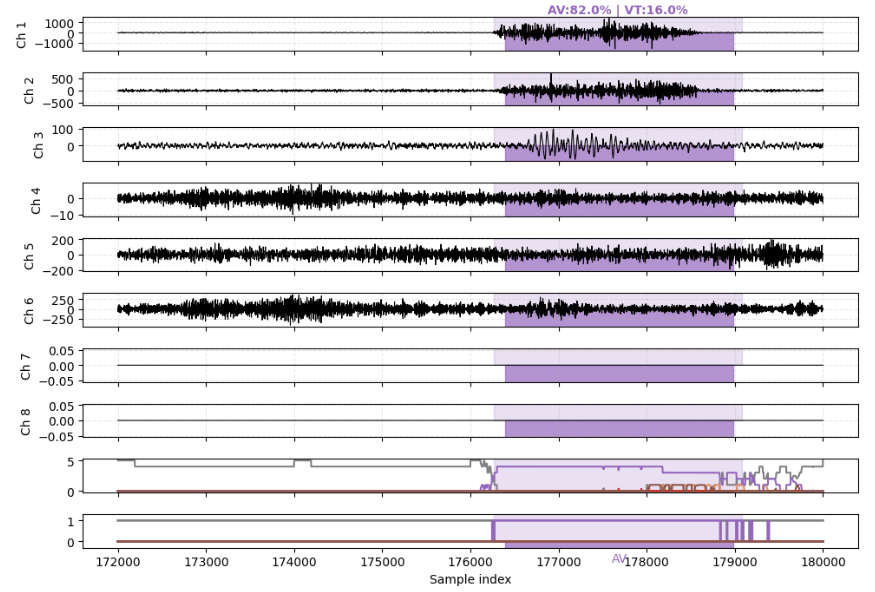

In [ ]:

display(Image(filename="../data/AV_correct.png"))

Incorrect detection of AV and IC

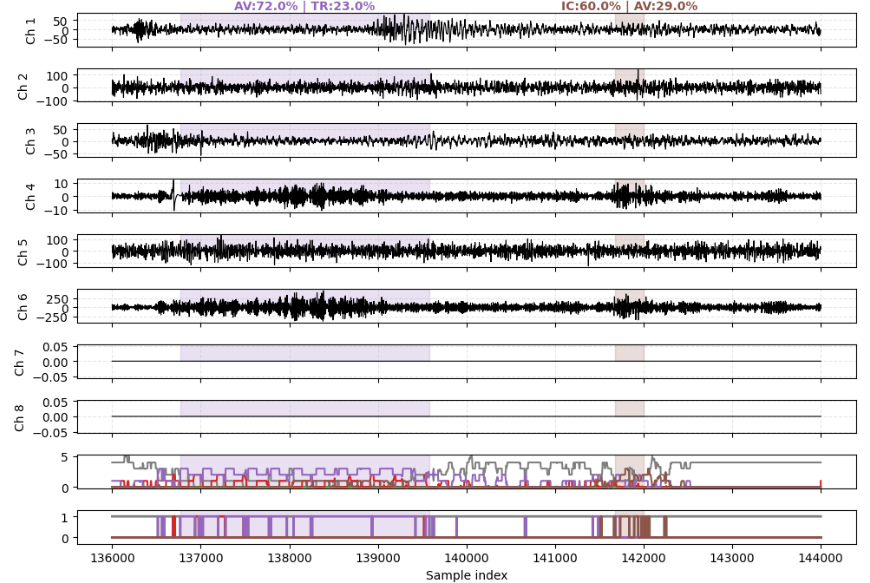

In [21]:
display(Image(filename="../data/AV_IC.png"))

Incorrect detection of TR

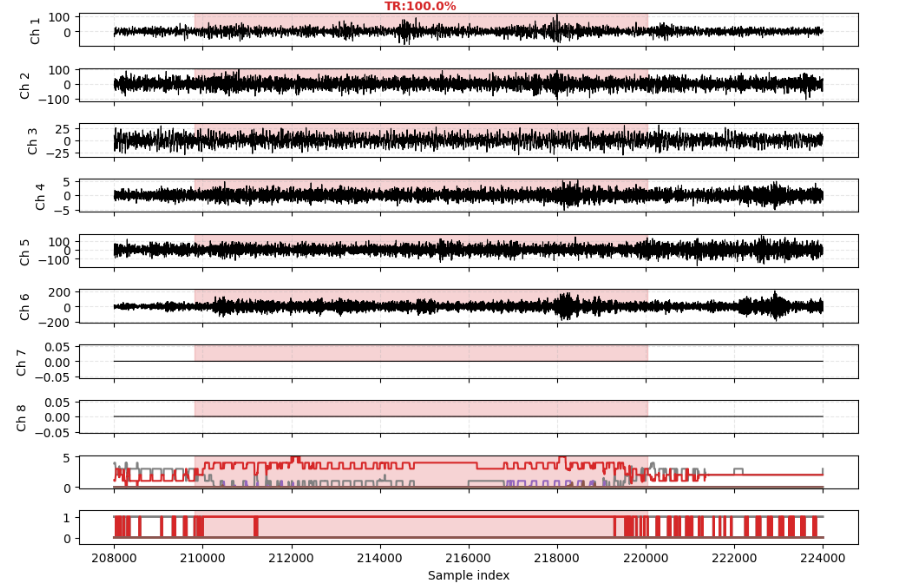

In [22]:
display(Image(filename="../data/TR.png"))

Incorrect detection of VT

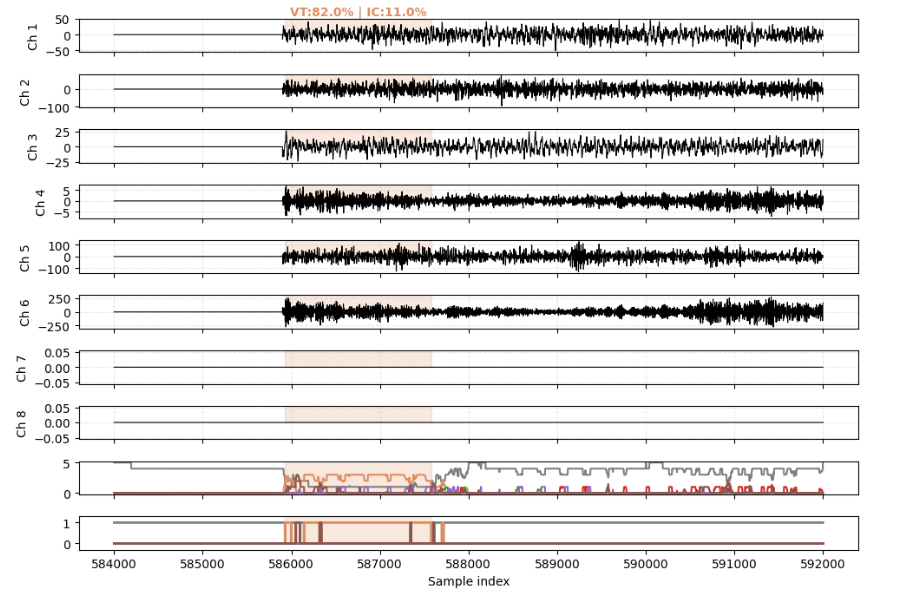

In [23]:
display(Image(filename="../data/VT.png"))

Incorrect detection of IC

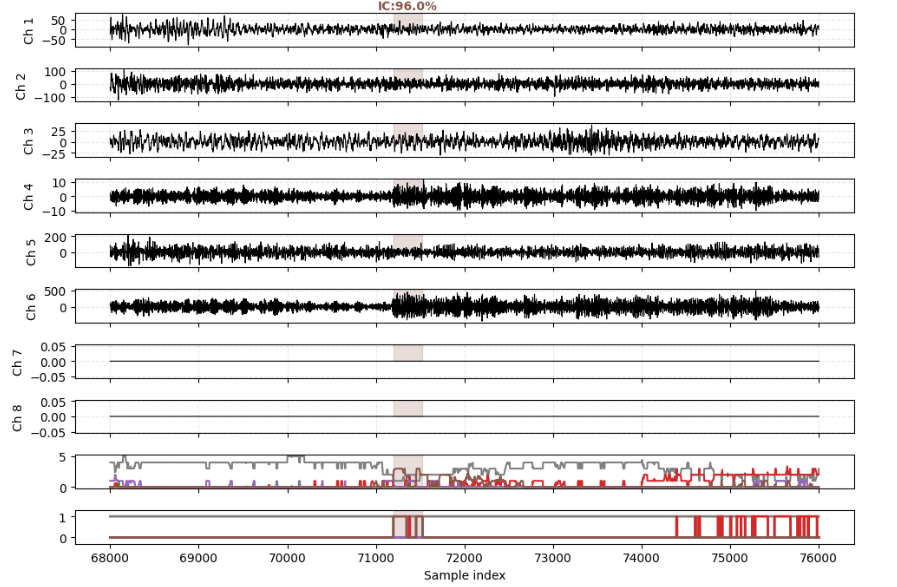

In [24]:
display(Image(filename="../data/IC.png"))

Incorrect detection of LP

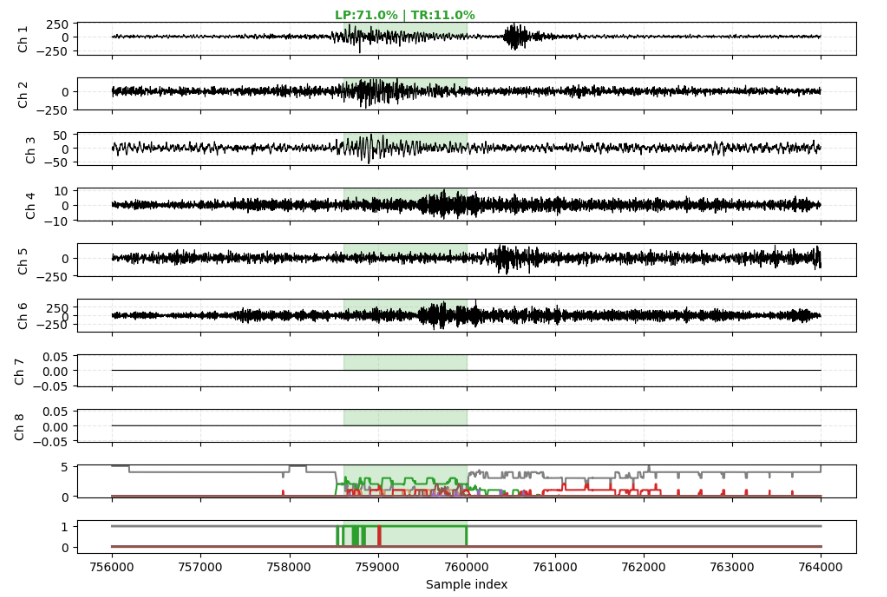

In [25]:
display(Image(filename="../data/LP.png"))

Correct detection of VT

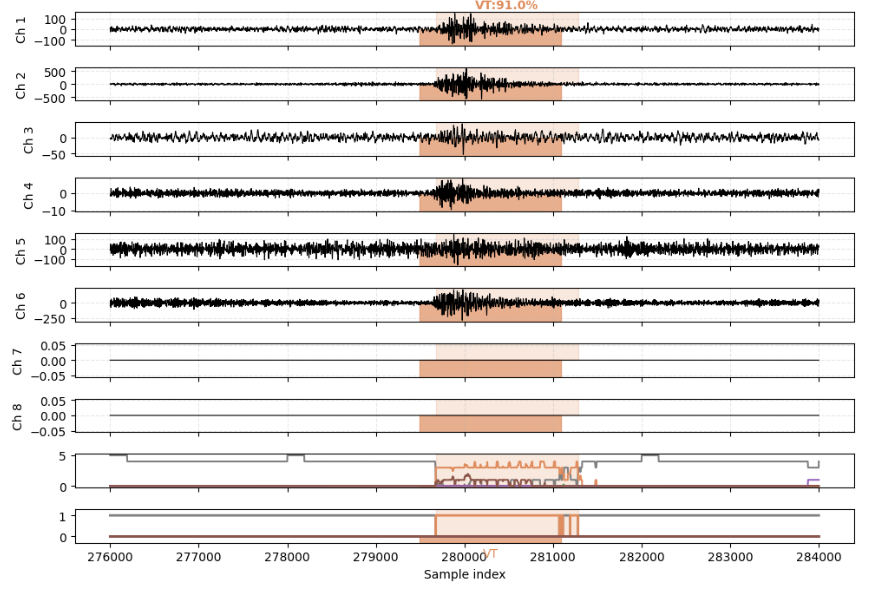

In [26]:
display(Image(filename="../data/VT_correct.png"))